# Classification Using CNN from PyTorch
## Goal:
Build a deep learning model to classify images using a CNN model with PyTorch and experiment with ways on improving accuracy.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tarfile

# 0. (Optional) Extract binary data from the ".tar.gz" file

If the user has not extracted the binary files from before, than the code below can be used to do so.

In [ ]:
current_folder = '/Users/doncheung/Desktop/AMSI/Assignment 2' # modify this according to your local file location containing the stl10_binary.tar.gz file
extract_this = f'{current_folder}/stl10_binary.tar.gz'
tar = tarfile.open(extract_this, "r:gz")
tar.extractall()
tar.close()

# 1. Loading the binary files

Instead of using ".png" files, we directly use the binary files as our data with the PyTorch CNN module.

In [2]:
def load_split(split): # train, test
    X_path = f'{path}{split}_X.bin'
    y_path = f'{path}{split}_y.bin'
    X = np.fromfile(X_path, dtype=np.uint8).reshape((-1, 3, 96, 96))
    X = np.moveaxis(X, 2, 3) # convert column-major to row-major
    y = np.fromfile(y_path, dtype=np.uint8) # data type seems to be important here...
    y = y - 1 #convert range [1,10] to [0,9]
    print('-----------------')
    print('Loaded split "{}" with sizes: Images {}, labels {}'.format(split, X.shape, y.shape))
    return X, y


path = '/media/gainsboro/The Common Space/stl10_binary/stl10_binary/'


full_train_X, full_train_y = load_split('train')
full_test_X, full_test_y = load_split('test')

-----------------
Loaded split "train" with sizes: Images (5000, 3, 96, 96), labels (5000,)
-----------------
Loaded split "test" with sizes: Images (8000, 3, 96, 96), labels (8000,)


# 2. View class names and images as a sanity check

In [4]:
with open(path+'class_names.txt') as f:
    full_class_names = f.readlines()

full_class_names = [name.strip() for name in full_class_names]

print('-----------------')
print('The classes in the dataset are: ')
print(list(enumerate(full_class_names)))

-----------------
The classes in the dataset are: 
[(0, 'airplane'), (1, 'bird'), (2, 'car'), (3, 'cat'), (4, 'deer'), (5, 'dog'), (6, 'horse'), (7, 'monkey'), (8, 'ship'), (9, 'truck')]


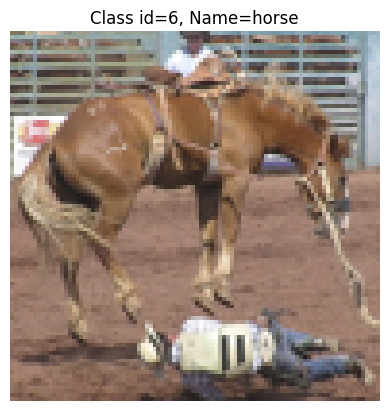

In [5]:
def visualize_sample(X, y, class_names):
    X_vis = np.moveaxis(X, 0, 2) # convert Channel,Width,Height order to W,H,C
    plt.figure()
    plt.imshow(X_vis, interpolation='nearest')
    plt.axis('off')
    plt.title('Class id={}, Name={}'.format(y, class_names[y]))

i = np.random.randint(0, full_train_X.shape[0]-1)
visualize_sample(full_train_X[i],
                 full_train_y[i],
                 full_class_names)

# 3. Define function for data augmentation

We apply the following augmentations to the training dataset:

- random horizontal flip with 50% probability

- rotation of each picture by up to 10 degrees clockwise/anticlockwise

In [6]:
from torchvision import transforms

train_transforms = transforms.Compose([ # applying data augmentation as a regulariser
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10)

])

class ArrayDataset(Dataset):
    def __init__(self, X, y, transform = None):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
        self.transform = transform
        
    def __len__(self):
        return self.X.shape[0]
  
    def __getitem__(self, index):
        image = self.X[index]
        label = self.y[index]

        if self.transform:
            image = self.transform(image)
            
        return image, label

# 4. Design the CNN architecture

In [15]:

class Sine(nn.Module):
    def __init__(self, w0: float = 1.0):
        """Sine activation function with w0 scaling support.

        Example:
            >>> w = torch.tensor([3.14, 1.57])
            >>> Sine(w0=1)(w)
            torch.Tensor([0, 1])

        :param w0: w0 in the activation step `act(x; w0) = sin(w0 * x)`.
            defaults to 1.0
        :type w0: float, optional
        """
        super(Sine, self).__init__()
        self.w0 = w0

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self._check_input(x)
        return torch.sin(self.w0 * x)

    @staticmethod
    def _check_input(x):
        if not isinstance(x, torch.Tensor):
            raise TypeError(
                'input to forward() must be torch.xTensor')



In [17]:
class CNN(nn.Module):
    def __init__(self, num_out_classes):
    
        super(CNN, self).__init__()
            
        # input: 3x96x96 -> output: 
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=32,
                               kernel_size=3,
                               padding=1,
                               stride=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=32)
        #self.relu1 = nn.ReLU()
        self.sine = Sine(1.0)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)


        self.conv2 = nn.Conv2d(in_channels=32,
                               out_channels=32*2,
                               kernel_size=3,
                               padding=1,
                               stride = 1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=32*2)
        #self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)


        self.conv3 = nn.Conv2d(in_channels=32*2,
                               out_channels=32*4,
                               kernel_size=3,
                               padding=1,
                               stride = 1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(num_features=32*4)
        #self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(32 * 4 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, num_out_classes)

        self.dropout_half = nn.Dropout(p=0.5)

    
    def forward(self, x):
        # bring input to [-1,1] range
        x = x.float() / 128.0 - 1.0
        # sequence of operations: convolution --> batch normalization --> non-linearity --> pooling
        x = self.pool1(self.sine(self.bn1(self.conv1(x))))
        x = self.pool2(self.sine(self.bn2(self.conv2(x))))
        x = self.pool3(self.sine(self.bn3(self.conv3(x))))  
        x = torch.flatten(x, 1)
        x = self.fc1(x) 
        x = self.dropout_half(torch.relu(x))  
        x = self.fc2(x)
        return x    

Review the summary of the CNN archictecture. This includes the output shapes and parameters involved for each layer.

In [8]:
from torchvision import models
from pytorch_model_summary import summary

vgg = CNN(10)
print(summary(vgg, torch.zeros(1, 3, 96, 96)))

ModuleNotFoundError: No module named 'pytorch_model_summary'

# 5. Define function for computing (training) accuracy

In [9]:
def compute_accuracy(data_loader,
                     cnn,
                     split,
                     print_output = True):
  
    cnn.eval() # sets the model into evaluation mode
    total_accuracy = 0
    total_samples = 0

    for i, batch in enumerate(data_loader):
        # get the inputs and labels
        X_batch, y_batch = batch
        # calculate predictions given a batch of samples      
        predictions_batch = cnn(X_batch)
        # convert each prediction into a class id
        _, vals = torch.max(predictions_batch, 1)
        # calculate the amount of predicted class ids matching the ground truth and increment counters
        total_accuracy += (vals == y_batch.type(torch.long)).int().sum()
        total_samples += y_batch.shape[0]
        out_accuracy = int(total_accuracy) * 1.0 / total_samples

    if print_output:
        print(f'Accuracy over "{split}" split is {100 * out_accuracy:02f}%')

    return 100 * out_accuracy

# 6. Define function for the training process

In [10]:
def train(cnn,
          loader_train,
          loader_test,
          num_epochs,
          learning_rate = 0.001,
          track_accuracy = True):
  
    criterion = nn.CrossEntropyLoss() #loss function
    # optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)
    optimizer = optim.Adam(cnn.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5) # dynamically update learning
    tr_acc, ts_acc, tr_loss, ts_loss = [], [], [], []

    # In each epoch, run the optimizer operation on each batch
    for epoch in range(num_epochs):
        cnn.train()     # set the model into training mode

        epoch_loss = 0.0
        for i, batch in enumerate(loader_train):
            X_batch, y_batch = batch
            y_batch = y_batch.type(torch.long)
            optimizer.zero_grad() # zero the parameter gradientsle
            predictions_batch = cnn(X_batch)             # forward pass
            loss = criterion(predictions_batch, y_batch)             # calculate loss for the provided predictions and ground truth labels
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
       
        ### Extra code for test loss (epoch loss is for training loss)
        cnn.eval()
        test_loss = 0.0
        with torch.no_grad():
            for i, batch in enumerate(loader_test):
                X_batch, y_batch = batch
                y_batch = y_batch.type(torch.long)
                predictions_batch = cnn(X_batch)
                loss2 = criterion(predictions_batch, y_batch)
                test_loss += loss2.item()
       
        if track_accuracy:
            tr_acc.append(compute_accuracy(data_loader = loader_train,
                                           cnn = cnn,
                                           split = 'train',
                                           print_output = False))
            ts_acc.append(compute_accuracy(data_loader = loader_test,
                                           cnn = cnn,
                                           split = 'test',
                                           print_output = False))
            
        epoch_loss /= len(loader_train)
        test_loss /= len(loader_test)
        tr_loss.append(epoch_loss)
        ts_loss.append(test_loss)
        print(f'Epoch {epoch+1}/{num_epochs} -> train loss {epoch_loss:02f}, test loss = {test_loss:02f}')
        scheduler.step()

    if track_accuracy:
        plt.figure(figsize=(12,5))

        plt.subplot(1,2,1)
        plt.plot(np.array(tr_acc))
        plt.plot(np.array(ts_acc))
        plt.legend(['train accuracy', 'test accuracy'])
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')

        plt.subplot(1,2,2)
        plt.plot(np.array(tr_loss))
        plt.plot(np.array(ts_loss))
        plt.legend(['train loss', 'test loss'])
        plt.title('Loss over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')

        plt.show()
        plt.close()

    print('Finished Training')

# 7. Training and testing process for 2 class classification

### 7. a) Split for 2 class classifcation

In [11]:
ID_C1_OLD, ID_C2_OLD = 3, 8 # C1: CAT, C2: SHIP
ID_C1_NEW, ID_C2_NEW = 0, 1

def subsplit_two_classes(X, y, split):
    indices = np.where(np.logical_or(y==ID_C1_OLD, y==ID_C2_OLD))
    X_out = X[indices]
    y_out = y[indices]
    y_out = (y_out == ID_C1_OLD).astype(np.uint8) * ID_C1_NEW + (y_out == ID_C2_OLD).astype(np.uint8) * ID_C2_NEW
    print('Created "{}" subsplit with only 2 classes with sizes: Images {}, labels {}'.format(split, X_out.shape, y_out.shape))
    return X_out, y_out

train_two_classes_X, train_two_classes_y = subsplit_two_classes(full_train_X,
                                                                full_train_y,
                                                                'train')

test_two_classes_X, test_two_classes_y = subsplit_two_classes(full_test_X,
                                                              full_test_y,
                                                              'test')

class_names_two_classes = [full_class_names[i] for i in (ID_C1_OLD, ID_C2_OLD)]

Created "train" subsplit with only 2 classes with sizes: Images (1000, 3, 96, 96), labels (1000,)
Created "test" subsplit with only 2 classes with sizes: Images (1600, 3, 96, 96), labels (1600,)


Visualising sample from the training set

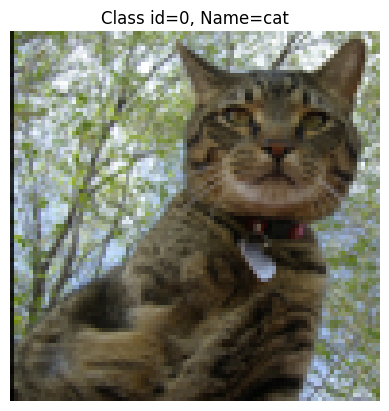

In [12]:
i = np.random.randint(0, train_two_classes_X.shape[0]-1)
visualize_sample(train_two_classes_X[i],
                 train_two_classes_y[i],
                 class_names_two_classes)

### 7. b) Load and augment the data for the 2 classes

In [13]:
BATCH_SIZE = 64

train_ds = ArrayDataset(train_two_classes_X, train_two_classes_y, transform=train_transforms)
loader_two_classes_train = DataLoader(dataset = train_ds,
                                      batch_size=BATCH_SIZE,
                                      shuffle=True,
                                      drop_last=True)

test_ds = ArrayDataset(test_two_classes_X, test_two_classes_y, transform=None)
loader_two_classes_test = DataLoader(dataset = test_ds,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False)

### 7. c) Check accuracy for untrained model.

Probabilistically, training/testing accuracy should be 50% as images are categorised with no information as a coin flip.

In [16]:
cnn_two_classes = CNN(num_out_classes = 2)
# compute the accuracy of the CNN... we have not yet trained it, so what do you expect the accuracy to be??
compute_accuracy(data_loader = loader_two_classes_train,
                 cnn = cnn_two_classes,
                 split = 'train')

compute_accuracy(data_loader = loader_two_classes_test,
                 cnn = cnn_two_classes,
                 split = 'test')

Accuracy over "train" split is 49.791667%
Accuracy over "test" split is 50.000000%


50.0

### 7. d) Now train the CNN for 2 classes

In [ ]:
train(cnn = cnn_two_classes,
      loader_train = loader_two_classes_train,
      loader_test = loader_two_classes_test,
      num_epochs = 20,
      track_accuracy = True)

### 7. e) Compute accuracy of the model after traning

In [28]:
compute_accuracy(data_loader = loader_two_classes_train,
                 cnn = cnn_two_classes,
                 split = 'train')

compute_accuracy(data_loader = loader_two_classes_test,
                 cnn = cnn_two_classes,
                 split = 'test')

Accuracy over "train" split is 98.437500%
Accuracy over "test" split is 96.250000%


96.25

# 8. Training and testing process for 10 class classification

### 8. a) Load and augment the data for the 2 classes

In [ ]:
BATCH_SIZE = 64

train_ds_ten = ArrayDataset(full_train_X, full_train_y, transform=train_transforms)
loader_ten_classes_train = DataLoader(dataset = train_ds_ten,
                                      batch_size=BATCH_SIZE,
                                      shuffle=True,
                                      drop_last=True)

test_ds_ten = ArrayDataset(full_train_X, full_train_y, transform=None)
loader_ten_classes_test = DataLoader(dataset = test_ds_ten,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False)

cnn_ten_classes = CNN(num_out_classes = 10) # CNN = Don, ConvNet = Johan

### 8. b) Check accuracy for untrained model.

Probabilistically, training/testing accuracy should be 10% as images are categorised with no information by random chance. The probability of an image belonging to the correct category is around 10%.


In [ ]:
compute_accuracy(data_loader = loader_ten_classes_train,
                 cnn = cnn_ten_classes,
                 split = 'train')

compute_accuracy(data_loader = loader_ten_classes_test,
                 cnn = cnn_ten_classes,
                 split = 'test')

### 8. c) Compute accuracy of the model after traning

Epoch 1/20 -> train loss 1.969734, test loss = 1.664347
Epoch 2/20 -> train loss 1.714742, test loss = 1.487927
Epoch 3/20 -> train loss 1.617491, test loss = 1.372248
Epoch 4/20 -> train loss 1.532881, test loss = 1.315679
Epoch 5/20 -> train loss 1.478925, test loss = 1.247537
Epoch 6/20 -> train loss 1.389759, test loss = 1.159239
Epoch 7/20 -> train loss 1.374633, test loss = 1.125271
Epoch 8/20 -> train loss 1.346176, test loss = 1.110497
Epoch 9/20 -> train loss 1.304318, test loss = 1.080115
Epoch 10/20 -> train loss 1.273244, test loss = 1.046621
Epoch 11/20 -> train loss 1.241539, test loss = 1.029607
Epoch 12/20 -> train loss 1.223674, test loss = 1.022760
Epoch 13/20 -> train loss 1.221511, test loss = 1.008561
Epoch 14/20 -> train loss 1.224033, test loss = 1.002135
Epoch 15/20 -> train loss 1.215329, test loss = 0.986508
Epoch 16/20 -> train loss 1.192033, test loss = 0.976407
Epoch 17/20 -> train loss 1.196147, test loss = 0.978300
Epoch 18/20 -> train loss 1.188088, test

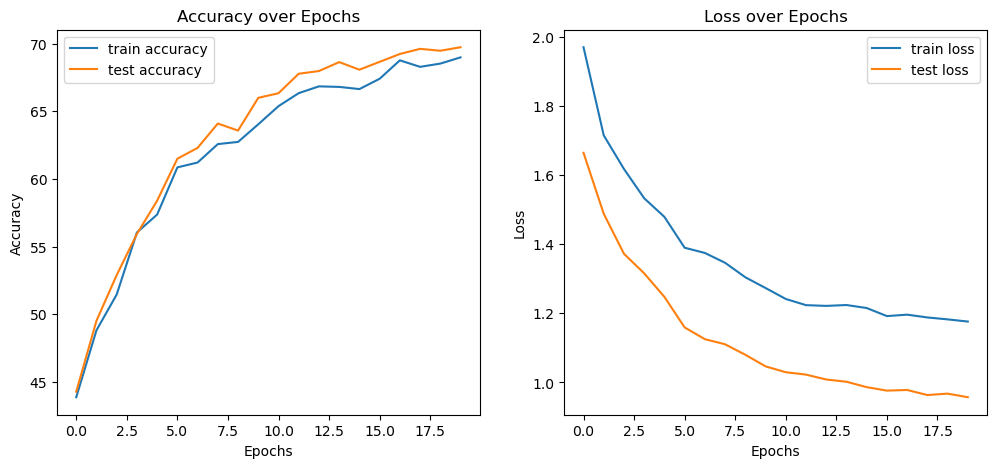

Finished Training


In [17]:
torch.set_num_threads(10)

train(cnn = cnn_ten_classes,
      loader_train = loader_ten_classes_train,
      loader_test = loader_ten_classes_test,
      num_epochs = 20,
      track_accuracy = True)

After training, computing accuracy for 10 class CNN model

In [18]:
compute_accuracy(data_loader = loader_ten_classes_train,
                 cnn = cnn_ten_classes,
                 split = 'train')

compute_accuracy(data_loader = loader_ten_classes_test,
                 cnn = cnn_ten_classes,
                 split = 'test')

Accuracy over "train" split is 68.129006%
Accuracy over "test" split is 69.740000%


69.74000000000001

# 9. Use the functions below to save and load the train models while retaining the trained weights.

Pytorch allows users to save their trained models, which retains the weights. These models can be investigated for further studied or even be trained further more more epochs.

In [ ]:
# torch.save(cnn_ten_classes.state_dict(), 'example.pth')

Epoch 1/20 -> train loss 1.225493, test loss = 0.998538
Epoch 2/20 -> train loss 1.198041, test loss = 0.944812
Epoch 3/20 -> train loss 1.159007, test loss = 0.962381
Epoch 4/20 -> train loss 1.171587, test loss = 0.900511
Epoch 5/20 -> train loss 1.121178, test loss = 0.842225
Epoch 6/20 -> train loss 1.083620, test loss = 0.827281
Epoch 7/20 -> train loss 1.047183, test loss = 0.800854
Epoch 8/20 -> train loss 1.058533, test loss = 0.800882
Epoch 9/20 -> train loss 1.022746, test loss = 0.783825
Epoch 10/20 -> train loss 1.024568, test loss = 0.771960
Epoch 11/20 -> train loss 0.989765, test loss = 0.745498
Epoch 12/20 -> train loss 0.984250, test loss = 0.742017
Epoch 13/20 -> train loss 0.976381, test loss = 0.734641
Epoch 14/20 -> train loss 0.966075, test loss = 0.720391
Epoch 15/20 -> train loss 0.965579, test loss = 0.730275
Epoch 16/20 -> train loss 0.956753, test loss = 0.719221
Epoch 17/20 -> train loss 0.952776, test loss = 0.720723
Epoch 18/20 -> train loss 0.948492, test

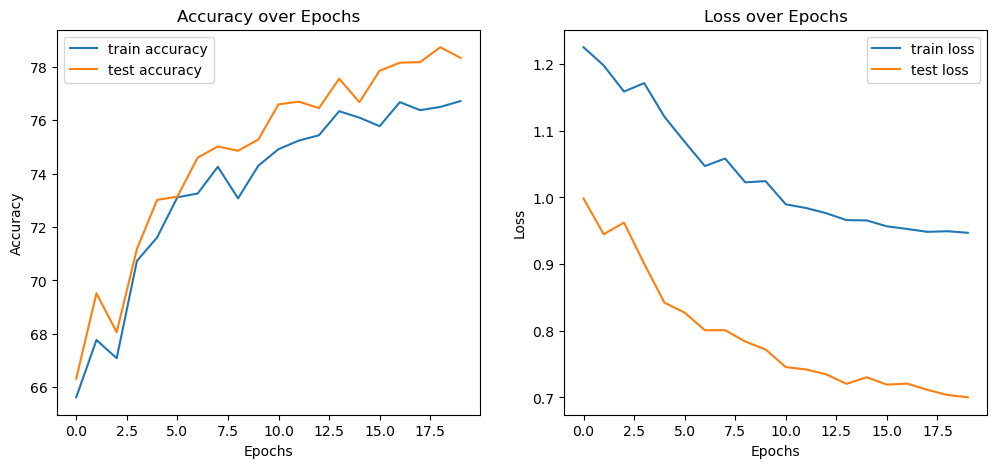

Finished Training


In [21]:
saved_model = CNN(num_out_classes=10)
saved_model.load_state_dict(torch.load('cnn_68_percent.pth', weights_only=True))

train(cnn = saved_model,
      loader_train = loader_ten_classes_train,
      loader_test = loader_ten_classes_test,
      num_epochs = 20,
      track_accuracy = True)

# 10. References